All steps must be executed in order to acheive the desired results

# Step 0: Setup and User Input



Required libraries and imports:

In [ ]:
!pip install qiskit==0.37.1
!pip install pylatexenc

In [24]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, BasicAer, Aer, IBMQ, execute
from qiskit.visualization import plot_state_qsphere
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from IPython.display import display
from math import sqrt, pow, pi
import numpy as np

## User Input
Feel free to change the values below to any values you'd like to see generated

`num_qubits` can be set from 2-5
`oracle_vector` must match the same number of bits and include 0, 1 only

In [98]:
num_qubits = 4
oracle_vector = '0101'

Some example values for above:

```
num_qubits = 2
oracle_vector = '11'
```
```
num_qubits = 3
oracle_vector = '101'
```
```
num_qubits = 4
oracle_vector = '0111'
```

## Registers

Initializing our registers

In [99]:
quantum_register = QuantumRegister(num_qubits)
classical_register = ClassicalRegister(num_qubits)

## Helper Functions

General helper functions

In [100]:
def ket_notation(vector: str):
    ket = '\u27E9'
    return '|' + vector + ket

def print_qsphere(circuit):
    qsphere = execute(circuit, Aer.get_backend('statevector_simulator')).result().get_statevector(circuit)
    display(plot_state_qsphere(qsphere))

def print_unitary_matrix(circuit):
    np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
    unitary = execute(circuit, BasicAer.get_backend('unitary_simulator')).result().get_unitary(circuit)
    print("Unitary matrix:\n"+ str(unitary.real))

# Step 1: Oracle

Grover's algorithm can be broken into three logic parts. The oracle, the amplifier, and finally putting those together into the set of gates that make up grovers algorithm. Below we build the oracle based on our user input

The logic when building an oracle:

1. We need to ensuree all 0 states are flipped to 1, so we apply a Pauli X gate (equivalent to the traditional NOT gate) to all starting 0 bits
2. We apply a Hadamard gate to the last qubit. This allows us to ensure that this qubit will be in the expected state of our solution
3. We then apply a controlled NOT gate depending on the number of qubits we are applying this oracle to. Each CNOT gate (CX, CCX (Toffoli), MCX) all target the final qubit which is the bit we applied our H gate to
4. We then finally apply another H and reverse our initial NOTs to return the qubits back to their initial state

We can see this logic clearly applied below

In [101]:
def initialize_oracle(oracle, quantum_register, oracle_vector):
    num_qubits = oracle.num_qubits
    # Applying Pauli-X gates to 0 values of our oracle vector
    reversed_oracle_vector = oracle_vector[::-1]
    for n in range(0, len(oracle_vector)):
        if reversed_oracle_vector[n] == '0':
            oracle.x(quantum_register[n])
    # Applying a Hadamard gate to our final qubit
    oracle.h(quantum_register[num_qubits - 1])
    # Applying a controlled NOT gate with our final qubit as the target
    if num_qubits == 2: oracle.cx(quantum_register[0], quantum_register[1])
    if num_qubits == 3: oracle.ccx(quantum_register[0], quantum_register[1], quantum_register[2])
    if num_qubits == 4: oracle.mcx([quantum_register[0], quantum_register[1], quantum_register[2]], quantum_register[3])
    if num_qubits == 5: oracle.mcx([quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3]], quantum_register[4])
    # Applying a Hadamard gate to our final qubit
    oracle.h(quantum_register[num_qubits - 1])
    # Applying Pauli-X gates to 0 values of our oracle vector
    for n in range(0, len(oracle_vector)):
        if reversed_oracle_vector[n] == '0':
            oracle.x(quantum_register[n])
    # Adding a bar for ease of visualization
    oracle.barrier(quantum_register)
    return oracle

Initializing the oracle

Oracle circuit for |0101⟩


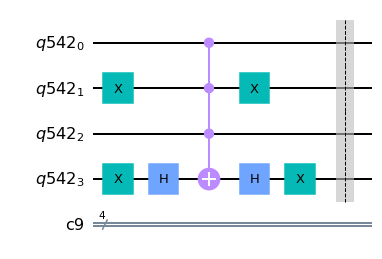

Unitary matrix:
[[1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00 -1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00
  0.00 0.00]
 [0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0

In [102]:
oracle = QuantumCircuit(quantum_register, classical_register)
oracle = initialize_oracle(oracle, quantum_register, oracle_vector)
print("Oracle circuit for " + ket_notation(str(oracle_vector)))
display(oracle.draw(output="mpl"))
print_unitary_matrix(oracle)

# Step 2: Amplitude Amplification

The next step is to build the amplitude amplification gates based on user input.

The logic when building a set of amplification gates:

1. Apply a Hadamar gate to all registers, followed by a Pauli X gate (NOT)
2. Similar to the oracle, we apply a H to our final qubit and follow with a CONTROLLED NOT with the final qubit as our target
3. Reverse the above H on the final qubit, then reverse the NOT and H on all qubits

In [103]:
def initialize_amplifier(amplifier, quantum_register):
    num_qubits = amplifier.num_qubits
    # Applying a Hadamard to all qubits
    amplifier.h(quantum_register)
    # Applying a NOT to all qubits
    amplifier.x(quantum_register)
    # Applying a Hadamard to the final qubit
    amplifier.h(quantum_register[num_qubits - 1])
    # Applying a controlled NOT gate with our final qubit as the target
    if num_qubits == 2: amplifier.cx(quantum_register[0], quantum_register[1]);
    if num_qubits == 3: amplifier.ccx(quantum_register[0], quantum_register[1], quantum_register[2])
    if num_qubits == 4: amplifier.mcx([quantum_register[0], quantum_register[1], quantum_register[2]], quantum_register[3])
    if num_qubits == 5: amplifier.mcx([quantum_register[0], quantum_register[1], quantum_register[2], quantum_register[3]], quantum_register[4])
    # Applying a Hadamard to the final qubit
    amplifier.h(quantum_register[num_qubits - 1])
    # Applying a NOT to all qubits
    amplifier.x(quantum_register)
    # Applying a Hadamard to all qubits
    amplifier.h(quantum_register)
    # Adding a bar for ease of visualization
    amplifier.barrier(quantum_register)
    return amplifier

Initialize the amplifier

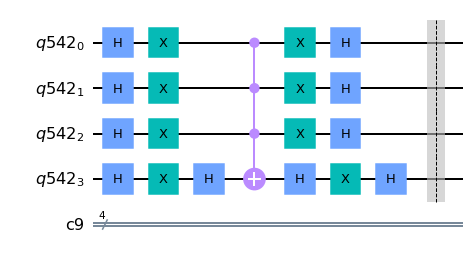

Unitary matrix:
[[0.87 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12
  -0.12 -0.12 -0.12 -0.12]
 [-0.12 0.87 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12
  -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12 0.87 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12
  -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12 -0.12 0.87 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12
  -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12 -0.12 -0.12 0.87 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12
  -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12 -0.12 -0.12 -0.12 0.87 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12
  -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12 -0.12 -0.12 -0.12 -0.12 0.87 -0.12 -0.12 -0.12 -0.12 -0.12
  -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 0.87 -0.12 -0.12 -0.12 -0.12
  -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 0.87 -0.12 -0.12 -0.12
  -0.12 -0.12 -0.12 -0.12]
 [-0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 -0.12 0.87 -0.12 -0.12
  -0.12 -0.

In [104]:
amplifier = QuantumCircuit(quantum_register, classical_register)
amplifier = initialize_amplifier(amplifier, quantum_register)
display(amplifier.draw(output="mpl"))
print_unitary_matrix(amplifier)

# Step 3: Grovers Algorithm

Final step before applying the gates is to combine the oracle and amplitude gates into the full stack of gates that represent Grover's algorithm. We first start with an empty quantum circuit. Below we can see the empty set of gates and uninitialized q sphere.

### Step 3.0 Initializing an empty QuantumCircuit

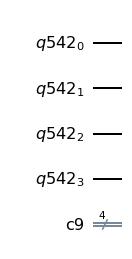

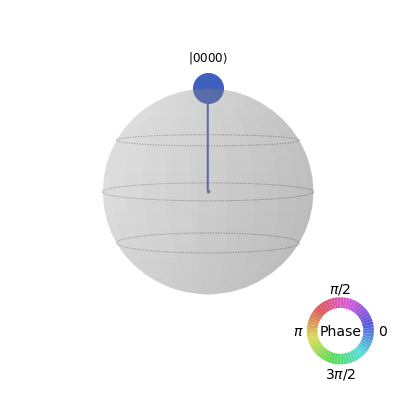

In [105]:
grover = QuantumCircuit(quantum_register, classical_register)
display(grover.draw(output="mpl"))
print_qsphere(grover)

### Step 3.1 Uniform Superposition

We must first initialize all the qubits we will be using into uniform superposition by applying Hadamard Gates to the n qubits we are initializing. We can see the hadamard gates and q sphere of our set of qubits

In [106]:
def initialize_grover(grover, quantum_register):
    # Initiate the Grover with Hadamards
    grover.h(quantum_register)
    grover.barrier(quantum_register)
    display(grover.draw(output="mpl"))
    print_qsphere(grover)
    return grover

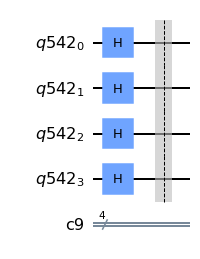

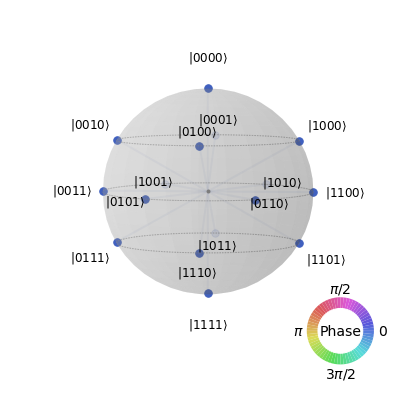

In [107]:
grover = initialize_grover(grover, quantum_register)

### Step 3.2 Applying the Oracle and Amplification 

The next step is to apply our oracle and amplification $\pi/4\sqrt{n}$ times, where n = our search space. By applying the orcale and amplification gates multiple times we help to maximize our chances of getting the expected output. If we apply these gates too many times however we will see our probability of a correct answer decrease

In [108]:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
search_space = pow(2, oracle.num_qubits)
number_of_iterations = int(pi / 4 * (sqrt(search_space)))

def build_grover(grover, oracle, amplifier, quantum_register, classic_register):
    step = 1
    for n in range(number_of_iterations):
        print('Step ' + str(step))
        print('Apply the oracle for the ' + ordinal(n + 1) + ' time')
        step += 1
        grover.compose(oracle, inplace=True)
        display(grover.draw(output="mpl"))
        print_qsphere(grover)
        print('=======================================================================')
        print('Step ' + str(step))
        print('Apply the amplifier for the ' + ordinal(n + 1) + ' time')
        step += 1
        grover.compose(amplifier, inplace=True)
        display(grover.draw(output="mpl"))
        print_qsphere(grover)
        print('=======================================================================')

    grover.measure(quantum_register, classic_register)
    return grover

Step 1
Apply the oracle for the 1st time


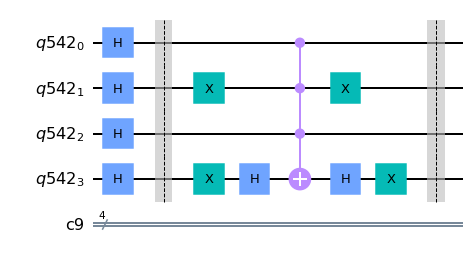

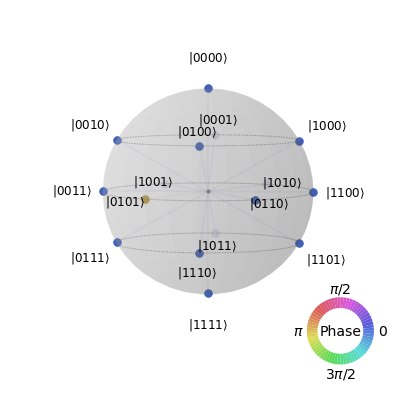

Step 2
Apply the amplifier for the 1st time


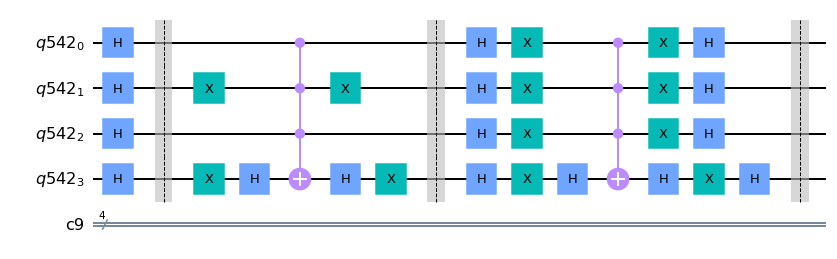

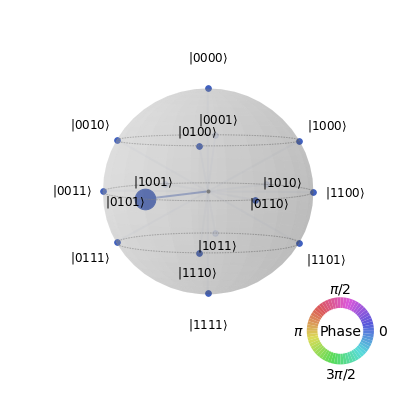

Step 3
Apply the oracle for the 2nd time


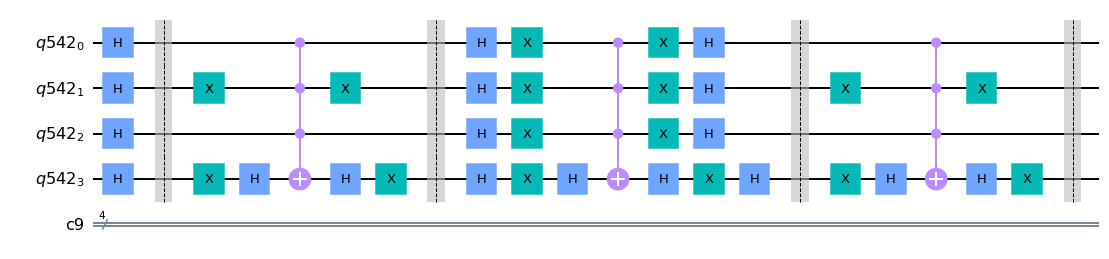

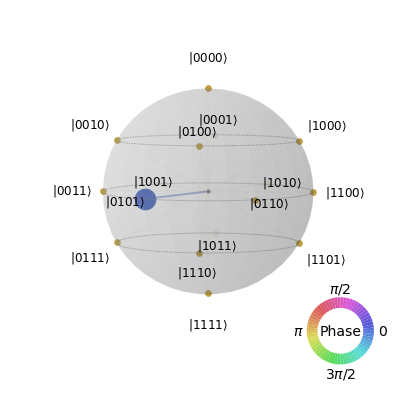

Step 4
Apply the amplifier for the 2nd time


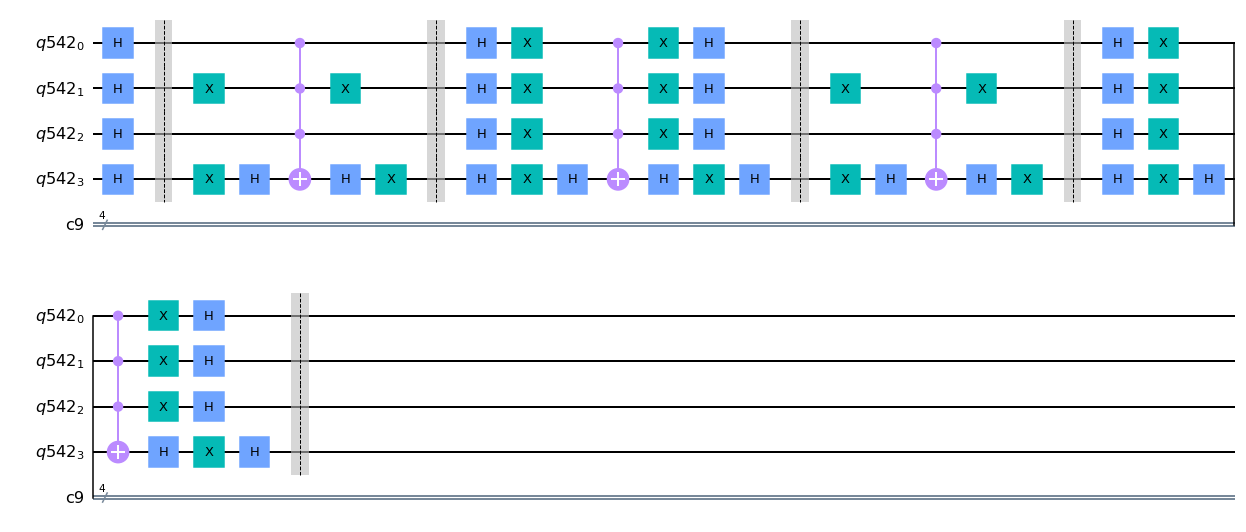

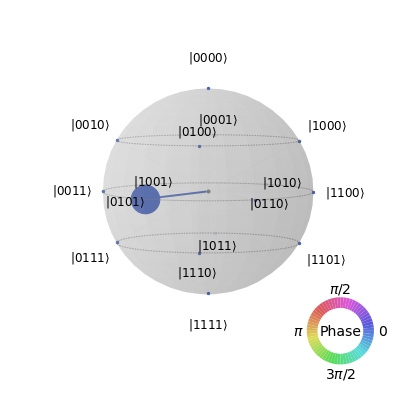

Step 5
Apply the oracle for the 3rd time


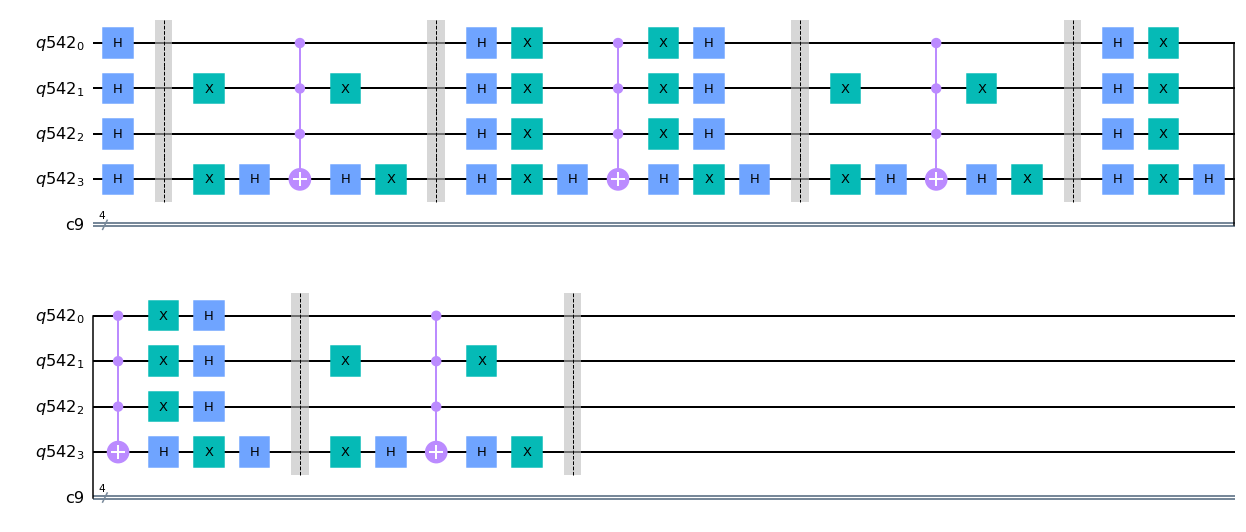

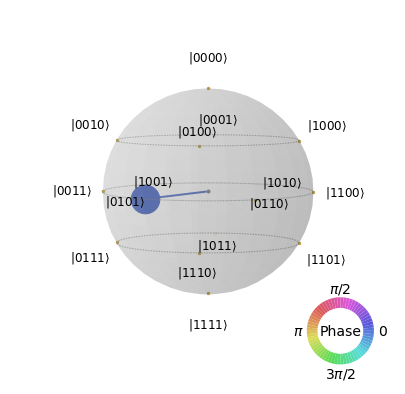

Step 6
Apply the amplifier for the 3rd time


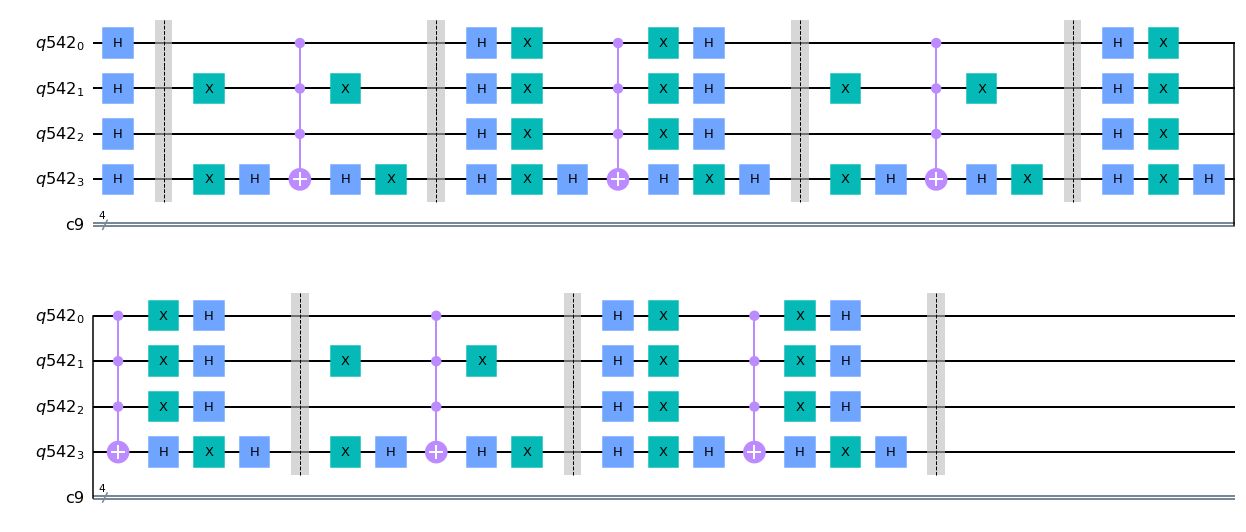

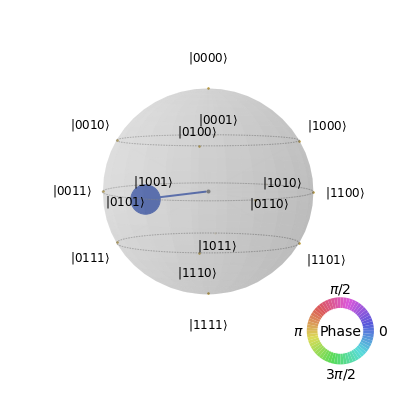

In [109]:
grover = build_grover(grover, oracle, amplifier, quantum_register, classical_register)

As we can see from the q sphere above, we have limited our expected qubit output to our user entered value.

Below is the full Grover's algorithm for the given search space:

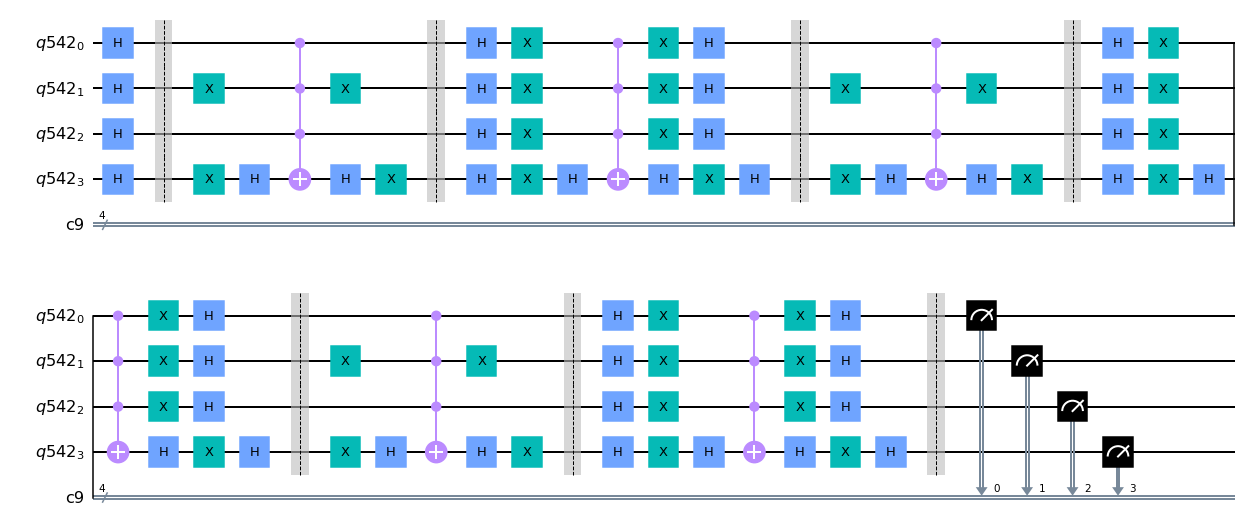

In [110]:
display(grover.draw(output="mpl"))

Now that our quantum circuit is built with the appropriate oracle, amplifier, and number of repitions, we can see how it performs in both a simulation and on real quantum hardware

# Step 4: Simulation

We can quickly and easily run our generated Grover's algorithm set of gates against a simulator to check the efficacy of the algorithm.

Statistical distribution of our search for |0101⟩ on a quantum computer emulator



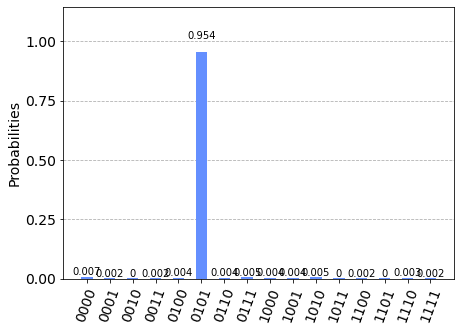

In [111]:
print("Statistical distribution of our search for " + ket_notation(str(oracle_vector)) + " on a quantum computer emulator\n")
simulation_results = execute(grover, Aer.get_backend('qasm_simulator')).result().get_counts()
display(plot_histogram(simulation_results))

# Step 5: Applying on Quantum Hardware


To run our generated Grover's algorithm on quantum hardware we are going to utilize IBMs quantum lab. You must have an account and can access or generate an API token [here](https://quantum-computing.ibm.com/account)

**Fair warning, this can take 2+ hours to execute depending on the queue of jobs**

In [ ]:
IBMQ.enable_account('<Enter your IBM API Token here>')

In [ ]:
queued_job = execute(grover, least_busy(IBMQ.get_provider().backends(n_qubits=5, operational=True, simulator=False)), shots=8192)
job_monitor(queued_job)

print("Statistical distribution of our search for " + ket_notation(str(oracle_vector)) + " on an IBM quantum computer\n")
hardware_results = queued_job.result().get_counts()
display(plot_histogram(hardware_results))